In [1]:
import os
import librosa
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew

In [3]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [4]:
# Set the seed
np.random.seed(42)

In [5]:
gtzan_dir = '/home/hp/BE_Proj/jupyternt/Music/genres/'

In [6]:
song_samples = 22050*30
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

In [7]:
def get_features(y, sr, n_fft = 1024, hop_length = 512):
    # Features to concatenate in the final dictionary
    features = {'centroid': None, 'roloff': None, 'flux': None, 'rmse': None,
                'zcr': None, 'contrast': None, 'bandwidth': None, 'flatness': None}
    
    # Count silence
    if 0 < len(y):
        y_sound, _ = librosa.effects.trim(y, frame_length=n_fft, hop_length=hop_length)
    features['sample_silence'] = len(y) - len(y_sound)

    # Using librosa to calculate the features
    features['centroid'] = librosa.feature.spectral_centroid(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['roloff'] = librosa.feature.spectral_rolloff(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['zcr'] = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['rmse'] = librosa.feature.rms(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['flux'] = librosa.onset.onset_strength(y=y, sr=sr).ravel()
    features['contrast'] = librosa.feature.spectral_contrast(y, sr=sr).ravel()
    features['bandwidth'] = librosa.feature.spectral_bandwidth(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['flatness'] = librosa.feature.spectral_flatness(y, n_fft=n_fft, hop_length=hop_length).ravel()
    
    # MFCC treatment
    mfcc = librosa.feature.mfcc(y, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
    for idx, v_mfcc in enumerate(mfcc):
        features['mfcc_{}'.format(idx)] = v_mfcc.ravel()
        
    # Get statistics from the vectors
    def get_moments(descriptors):
        result = {}
        for k, v in descriptors.items():
            result['{}_max'.format(k)] = np.max(v)
            result['{}_min'.format(k)] = np.min(v)
            result['{}_mean'.format(k)] = np.mean(v)
            result['{}_std'.format(k)] = np.std(v)
            result['{}_kurtosis'.format(k)] = kurtosis(v)
            result['{}_skew'.format(k)] = skew(v)
        return result
    
    dict_agg_features = get_moments(features)
    dict_agg_features['tempo'] = librosa.beat.tempo(y, sr=sr)[0]
    
    return dict_agg_features

In [8]:
def read_process_songs(src_dir, debug = True):    
    # Empty array of dicts with the processed features from all files
    arr_features = []

    # Read files from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        
        for root, subdirs, files in os.walk(folder):
            for file in files:
                # Read the audio file
                file_name = folder + "/" + file
                signal, sr = librosa.load(file_name)
                
                # Debug process
                if debug:
                    print("Reading file: {}".format(file_name))
                
                # Append the result to the data structure
                features = get_features(signal, sr)
                features['genre'] = genres[x]
                arr_features.append(features)
    return arr_features

In [9]:
%%time

features = read_process_songs(gtzan_dir, debug=False)

CPU times: user 18min 34s, sys: 7min 20s, total: 25min 55s
Wall time: 12min 35s


In [10]:
df_features = pd.DataFrame(features)

In [11]:
df_features.shape

(1000, 134)

In [12]:
df_features.head()

,centroid_max,centroid_min,centroid_mean,centroid_std,centroid_kurtosis,centroid_skew,roloff_max,roloff_min,roloff_mean,roloff_std,...,mfcc_11_kurtosis,mfcc_11_skew,mfcc_12_max,mfcc_12_min,mfcc_12_mean,mfcc_12_std,mfcc_12_kurtosis,mfcc_12_skew,tempo,genre
0,3763.003935,543.308383,1916.174010,585.415692,-0.451655,-0.057400,8031.884766,473.730469,4113.391368,1170.620398,...,0.185810,0.204371,15.856697,-29.054155,-8.306104,7.436500,0.197962,0.307333,112.347147,0
1,5952.646726,1080.639832,2777.188529,597.434429,3.121226,0.845066,8311.816406,2540.917969,5837.979445,861.814240,...,0.587073,-0.308574,18.938828,-32.047089,-6.559793,8.022807,0.065357,0.177972,161.499023,0
2,4428.644005,1361.280926,2675.731095,488.185761,0.195966,0.523736,7730.419922,2906.982422,5349.610395,906.740422,...,0.098584,-0.241992,8.338059,-35.737545,-13.719345,6.286901,0.294574,0.047421,112.347147,0
3,5514.393296,1789.366583,3176.995746,550.485825,1.277930,0.851571,9905.273438,4005.175781,6235.702536,1316.782580,...,-0.381803,-0.087361,20.820358,-32.647717,-4.103275,8.186303,0.171622,-0.170111,95.703125,0
4,4679.959464,579.444176,2594.710477,717.402348,-0.273551,0.075716,7428.955078,667.529297,4953.069714,1312.870066,...,0.230318,-0.720155,9.764196,-34.910488,-14.369601,7.955021,-0.332166,0.190768,95.703125,0


In [13]:
df_features.to_csv('/home/hp/BE_Proj/jupyternt/Music/gtzan_features.csv', index=False)

In [14]:
X = df_features.drop(['genre'], axis=1).values
y = df_features['genre'].values

In [15]:
# Standartize the dataset
scale = StandardScaler()
x_scaled = scale.fit_transform(X)

In [16]:
# Use PCA only for visualization
pca = PCA(n_components=35, whiten=True)
x_pca = pca.fit_transform(x_scaled)
print("cumulative explained variance ratio = {:.4f}".format(np.sum(pca.explained_variance_ratio_)))

cumulative explained variance ratio = 0.8737


In [17]:
# Use LDA only for visualization
lda = LDA()
x_lda = lda.fit_transform(x_scaled, y)

In [18]:
# Using tsne
tsne = TSNE(n_components=2, verbose=1, learning_rate=250)
x_tsne = tsne.fit_transform(x_scaled)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.084s...
[t-SNE] Computed neighbors for 1000 samples in 0.277s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 3.258476
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.496796
[t-SNE] KL divergence after 1000 iterations: 1.033287


In [20]:
# Helper to plot confusion matrix -- from Scikit-learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [22]:
# DECISIOSN TREE

params = {
    "cls__criterion": ["gini", "entropy"],
    "cls__splitter": ["best", "random"],
}

pipe_cart = Pipeline([
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', DecisionTreeClassifier())
])

grid_cart = GridSearchCV(pipe_cart, params, scoring='accuracy', n_jobs=6, cv=5)
grid_cart.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', DecisionTreeClassifier())]),
             n_jobs=6,
             param_grid={'cls__criterion': ['gini', 'entropy'],
                         'cls__splitter': ['best', 'random']},
             scoring='accuracy')

In [28]:
preds = grid_cart.predict(X_test)
print(preds)

[7 5 0 8 8 5 2 4 4 5 4 3 3 2 9 9 5 2 9 4 7 9 2 3 7 0 0 8 2 4 1 8 1 0 7 8 5
 1 5 3 5 5 1 0 0 6 5 4 0 8 6 4 6 2 9 8 6 9 2 0 6 0 0 9 8 7 2 8 6 8 0 7 2 4
 3 8 5 1 4 6 1 2 7 5 8 3 3 0 1 2 7 8 7 6 7 7 8 5 2 1 6 3 6 2 5 9 7 4 5 0 5
 4 3 7 3 6 8 8 8 3 9 1 0 3 6 0 9 7 7 1 8 8 2 5 5 9 1 0 3 8 2 2 9 1 5 3 2 8
 4 6 5 1 2 4 4 3 4 2 6 7 3 4 5 1 1 2 2 6 6 7 6 9 3 6 9 4 3 4 9 0 8 5 9 5 8
 3 0 2 7 7 0 4 5 2 3 7 5 7 6 7 6 5 1 4 8 2 4 4 2 6 3 1 6 7 8 0 5 8 9 8 6 7
 5 9 6 8 2 8 0 2 2 6 0 0 5 0 7 0 1 6 8 4 0 1 8 1 8 2 8 5]


In [30]:
print(y_test)
print("Score on validation set (accuracy) = {:.4f}".format(grid_cart.best_score_))
print("Score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

[4 7 0 8 8 3 7 4 4 9 4 3 1 9 9 1 5 2 6 5 7 5 7 0 7 0 0 1 2 9 6 8 8 0 5 6 5
 9 7 3 6 9 1 7 9 6 7 4 3 8 6 4 6 2 1 6 6 4 2 9 9 3 9 8 8 7 2 1 4 1 0 1 2 9
 3 8 5 1 4 6 0 2 7 5 1 0 3 0 9 2 3 1 4 6 7 7 3 5 2 1 6 3 6 2 5 5 9 4 4 0 5
 5 8 7 6 6 8 3 3 9 5 1 0 8 6 0 4 9 4 8 8 1 2 9 6 9 3 7 9 3 2 2 8 1 5 3 2 7
 4 8 2 6 2 4 7 3 4 2 6 7 3 4 9 5 0 2 2 9 1 7 6 3 0 3 9 4 3 4 9 0 7 9 8 5 8
 3 0 2 8 7 0 1 5 2 0 7 1 8 6 7 6 9 7 4 1 4 1 4 4 5 3 5 6 5 8 0 5 3 8 8 9 5
 2 1 6 8 2 8 0 2 2 3 0 0 5 0 7 0 7 1 3 4 0 1 6 1 5 1 8 5]
Score on validation set (accuracy) = 0.5080
Score on test set (accuracy) = 0.5440


In [31]:
# SVM

params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['rbf', 'linear', 'sigmoid'],
}

pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SVC())
])

grid_svm = GridSearchCV(pipe_svm, params, scoring='accuracy', n_jobs=6, cv=5)
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', SVC())]),
             n_jobs=6,
             param_grid={'cls__C': [0.5, 1, 2, 5],
                         'cls__kernel': ['rbf', 'linear', 'sigmoid']},
             scoring='accuracy')

In [32]:
preds = grid_svm.predict(X_test)
print(preds)

[4 7 0 8 8 6 5 4 4 9 4 2 1 2 9 1 1 2 5 5 7 5 7 0 7 0 8 1 2 9 9 8 8 0 9 6 5
 9 7 3 5 9 1 7 0 6 7 4 3 8 6 4 6 2 3 9 6 9 2 9 1 3 9 1 8 9 2 1 4 6 0 1 2 9
 3 8 5 1 4 6 0 2 7 5 1 0 3 0 7 2 0 8 4 6 7 7 8 5 2 1 3 3 6 2 5 5 9 4 4 0 5
 5 8 7 6 6 8 8 3 0 9 3 1 6 6 0 4 9 4 8 8 1 2 5 9 9 3 7 8 3 2 2 7 1 5 3 2 7
 4 6 2 3 2 4 7 3 4 2 6 7 3 4 9 1 0 2 2 9 1 7 6 3 0 3 9 4 3 4 9 0 7 5 8 5 8
 3 0 2 8 8 0 1 5 2 0 7 1 9 6 7 1 9 7 4 8 4 9 4 4 5 3 5 6 5 8 0 5 3 9 8 9 5
 4 1 6 8 2 3 0 2 2 3 0 0 5 0 7 0 7 1 8 4 0 1 3 1 1 2 8 5]


In [34]:
print(y_test)
print("Score on validation set (accuracy) = {:.4f}".format(grid_svm.best_score_))
print("Score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

[4 7 0 8 8 3 7 4 4 9 4 3 1 9 9 1 5 2 6 5 7 5 7 0 7 0 0 1 2 9 6 8 8 0 5 6 5
 9 7 3 6 9 1 7 9 6 7 4 3 8 6 4 6 2 1 6 6 4 2 9 9 3 9 8 8 7 2 1 4 1 0 1 2 9
 3 8 5 1 4 6 0 2 7 5 1 0 3 0 9 2 3 1 4 6 7 7 3 5 2 1 6 3 6 2 5 5 9 4 4 0 5
 5 8 7 6 6 8 3 3 9 5 1 0 8 6 0 4 9 4 8 8 1 2 9 6 9 3 7 9 3 2 2 8 1 5 3 2 7
 4 8 2 6 2 4 7 3 4 2 6 7 3 4 9 5 0 2 2 9 1 7 6 3 0 3 9 4 3 4 9 0 7 9 8 5 8
 3 0 2 8 7 0 1 5 2 0 7 1 8 6 7 6 9 7 4 1 4 1 4 4 5 3 5 6 5 8 0 5 3 8 8 9 5
 2 1 6 8 2 8 0 2 2 3 0 0 5 0 7 0 7 1 3 4 0 1 6 1 5 1 8 5]
Score on validation set (accuracy) = 0.7827
Score on test set (accuracy) = 0.8040


In [35]:
# Random Forest
params = {
    "cls__n_estimators": [100, 250, 500, 1000],
    "cls__criterion": ["gini", "entropy"],
    "cls__max_depth": [5, 7, None]
}

pipe_rf = Pipeline([
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', RandomForestClassifier())
])

grid_rf = GridSearchCV(pipe_rf, params, scoring='accuracy', n_jobs=6, cv=5)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', RandomForestClassifier())]),
             n_jobs=6,
             param_grid={'cls__criterion': ['gini', 'entropy'],
                         'cls__max_depth': [5, 7, None],
                         'cls__n_estimators': [100, 250, 500, 1000]},
             scoring='accuracy')

In [36]:
#Random Forest
preds = grid_rf.predict(X_test)
print(preds)

[4 7 0 8 8 6 7 4 4 9 4 3 1 4 9 1 7 2 9 7 7 1 7 0 7 0 3 8 2 4 9 8 8 0 1 6 5
 7 5 3 5 9 1 9 0 6 7 4 3 8 6 4 6 2 1 8 6 5 2 0 6 3 1 5 8 9 2 1 8 6 0 1 2 9
 3 8 5 1 4 6 0 2 7 5 1 3 3 0 1 2 0 8 4 6 7 7 8 5 2 1 6 8 6 2 5 5 1 4 4 0 5
 5 8 7 6 6 8 8 6 0 9 3 0 6 6 0 4 9 4 8 8 1 2 8 8 9 3 7 8 8 2 2 1 1 5 3 2 8
 4 6 2 1 2 2 7 3 4 2 6 7 3 4 4 1 0 2 2 4 1 7 6 3 0 8 9 4 3 4 7 0 7 5 8 5 8
 3 0 2 8 7 0 9 5 2 0 7 4 4 6 7 6 4 1 4 6 4 9 4 4 5 3 5 6 5 8 0 5 3 1 8 9 5
 2 1 6 8 2 8 0 2 2 3 0 0 7 0 4 0 1 6 8 4 0 3 3 1 6 2 8 8]


In [37]:
print(y_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_rf.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

[4 7 0 8 8 3 7 4 4 9 4 3 1 9 9 1 5 2 6 5 7 5 7 0 7 0 0 1 2 9 6 8 8 0 5 6 5
 9 7 3 6 9 1 7 9 6 7 4 3 8 6 4 6 2 1 6 6 4 2 9 9 3 9 8 8 7 2 1 4 1 0 1 2 9
 3 8 5 1 4 6 0 2 7 5 1 0 3 0 9 2 3 1 4 6 7 7 3 5 2 1 6 3 6 2 5 5 9 4 4 0 5
 5 8 7 6 6 8 3 3 9 5 1 0 8 6 0 4 9 4 8 8 1 2 9 6 9 3 7 9 3 2 2 8 1 5 3 2 7
 4 8 2 6 2 4 7 3 4 2 6 7 3 4 9 5 0 2 2 9 1 7 6 3 0 3 9 4 3 4 9 0 7 9 8 5 8
 3 0 2 8 7 0 1 5 2 0 7 1 8 6 7 6 9 7 4 1 4 1 4 4 5 3 5 6 5 8 0 5 3 8 8 9 5
 2 1 6 8 2 8 0 2 2 3 0 0 5 0 7 0 7 1 3 4 0 1 6 1 5 1 8 5]
best score on validation set (accuracy) = 0.7133
best score on test set (accuracy) = 0.7160


In [38]:
cm = confusion_matrix(y_test, preds)
classes = ['metal', 'disco', 'classical', 'hiphop', 'jazz', 'country', 'pop', 'blues', 'reggae', 'rock']

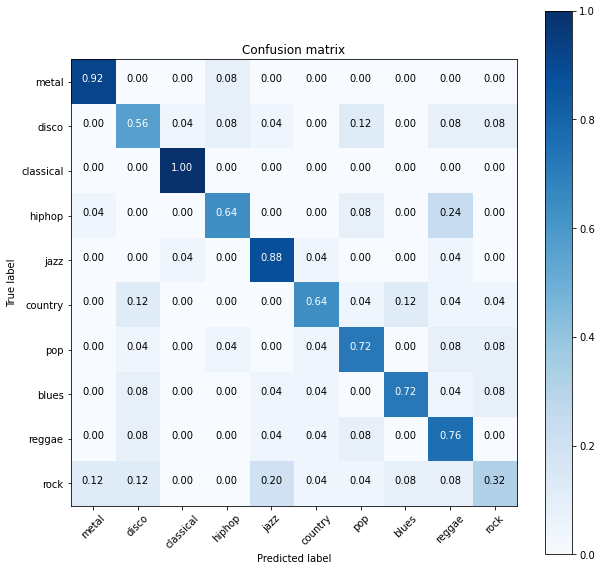

In [39]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)